In [1]:
import sys

import matplotlib.pyplot as plt
import json
import os.path
import itertools

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Make datasets without noise

In [ ]:
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)

num_periods = {
    "train": 12,
    "test": 12
}
for (ts_type, subset, pts_per_period) in itertools.product(
                                                      ["univariate", "multivariate"], 
                                                      ["train", "test"], 
                                                      [15, 100]
                                                    ):
    output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    dataset = dict()

    for i, name in enumerate(get_attractor_list()):
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                                       resample=True, return_times=True)


        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)

# Make dataset with noise

In [250]:
# sol = model.make_trajectory(1000, pts_per_period=pts_per_period, resample=True)

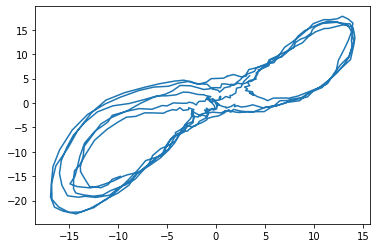

In [78]:

sol = Lorenz().make_trajectory(500, noise=0.2, resample=True)
plt.plot(sol[:, 0], sol[:, 1])

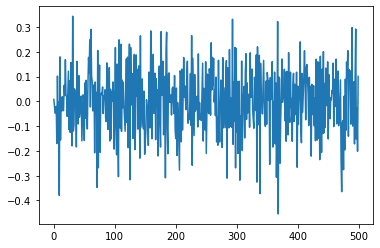

In [273]:
plt.plot(sol[:, 0]- sol_detrend)

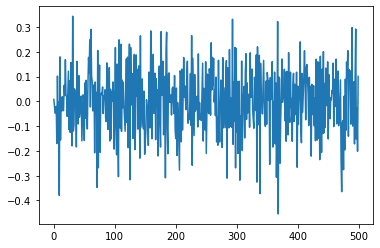

In [277]:
plt.plot(sol[:, 0]- sol_detrend)

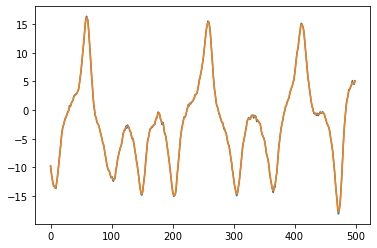

In [276]:
import scipy.signal
# sol_detrend = scipy.signal.detrend(sol[:, 0])

plt.plot(sol[:, 0])
plt.plot(sol_detrend)

In [75]:
# import errno
# import os
# import signal
# import functools

# class TimeoutError(Exception):
#     pass

# def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
#     def decorator(func):
#         def _handle_timeout(signum, frame):
#             raise TimeoutError(error_message)

#         @functools.wraps(func)
#         def wrapper(*args, **kwargs):
#             signal.signal(signal.SIGALRM, _handle_timeout)
#             signal.alarm(seconds)
#             try:
#                 result = func(*args, **kwargs)
#             finally:
#                 signal.alarm(0)
#             return result

#         return wrapper

#     return decorator



import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [80]:
qq = sample_initial_conditions(model, 3)
qq2 = sample_initial_conditions(model, 1)

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1361.6323363431152
  warnings.warn(


In [82]:
qq2

array([[-1.21678663e+00,  6.99678421e-02,  7.59514260e+02]])

In [83]:
import time

In [85]:
complete_flag = False
while not complete_flag:
    try:
        with timeout(seconds=3):
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                           resample=True, return_times=True)
            complete_flag = True
    except:
        np.random.random() # just to make sure seed iterates
        [new_ic] = sample_initial_conditions(model, 1)
        model.ic = new_ic
        print("Retrying...")

TimeoutError: Timeout

In [22]:
import scipy.signal
DATA_BASEPATH = "../dysts/data/"
np.random.seed(0)


import torch
from torchsde import sdeint
from dysts.flows import Lorenz
class SDE(torch.nn.Module):

    def __init__(self, rhs, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"
        self.sigma = sigma
        self.rhs = rhs

    def f(self, t, y):
        return self.rhs(y, t)

    def g(self, t, y):
        return self.sigma * y


# ts_type = "multivariate"
# subset = "train"
# pts_per_period = 15 # granularity 15 or 100
# pts_per_period = 100 # granularity 15 or 100


# num_periods = {
#     "large": 100,
#     "train": 10,
#     "val": 2,
#     "test": 2
# }

## iterate over uni/multi, train partition, and granularity
# for (ts_type, subset, pts_per_period) in itertools.product(
#                                                       ["univariate", "multivariate"], 
#                                                       ["train", "val", "test"], 
#                                                       [15, 100]
#                                                     ):

# for (ts_type, subset, pts_per_period) in [("univariate", "large", 100)]:

NOISE_FLAG = True
num_periods = {
    "train": 12,
    "test": 12
}

ts_combos = list(itertools.product(
    ["multivariate", "univariate"], 
    ["train", "test"], 
    [100, 15]
))

for (ts_type, subset, pts_per_period) in ts_combos:
    
    print(ts_type, subset, pts_per_period)
    
    if NOISE_FLAG:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}_noise.json")
    else:
        output_path = os.path.join(DATA_BASEPATH, f"{subset}_{ts_type}__pts_per_period_{pts_per_period}__periods_{num_periods[subset]}.json")
    
    dataset = dict()

    for i, name in enumerate(get_attractor_list()[:]):
        
#         if name not in ["ForcedVanDerPol", "JerkCircuit", "LiuChen", "BeerRNN"]:
#             continue
        
    
#         if name not in ["PiecewiseCircuit"]:
#             continue
        
        print(name)
        dataset[name] = dict()
        model = getattr(dysts.flows, name)()
        # make initial conditions for train, val, test
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)
        
        [train_ic, val_ic, test_ic] = sample_initial_conditions(model, 3)

        if subset == "train":
            model.ic = train_ic
        elif subset == "val":
            model.ic = val_ic
        elif subset == "test":
            model.ic = test_ic
        else:
            pass
        
        
        tpts, sol = model.make_trajectory(num_periods["train"] * 100, pts_per_period=100, 
                               resample=True, return_times=True)
        
        
        
#         sol = model.make_trajectory(500, pts_per_period=pts_per_period, resample=True)
        #noise_scale = 0.02 * np.median(np.abs(sol))
        #noise_scale = 0.01 * np.max(np.median(np.abs(sol), axis=1))
        #noise_scale = 0.01 * np.min(np.median(np.abs(sol), axis=1))
#         noise_scale = 0.02 * np.max(np.std(sol, axis=0))
#         noise_scale = 0.01
        #noise_scale = 0.01 * np.min(np.std(sol, axis=0))
        #noise_scale = 0.02 * np.median(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         noise_scale =  0.01 * np.max(np.std(sol, axis=0)) / (10 * np.sqrt(model.dt))
#         print(model.dt, model.period)
        
        
#         ref_traj = model.make_trajectory(5000, pts_per_period=pts_per_period, resample=False)
#         noise_traj = model.make_trajectory(5000, noise=0.5, pts_per_period=pts_per_period, resample=False)
#         noise_scale = np.max(np.sqrt(np.abs(np.var(noise_traj, axis=0) - np.var(ref_traj, axis=0))))
#         noise_scale = 0.1 * 1.5 / noise_scale
        
#         ref_traj = model.make_trajectory(2, pts_per_period=pts_per_period, resample=True)
#         noise_traj = model.make_trajectory(2, noise=0.5, pts_per_period=pts_per_period, resample=True)
#         noise_scale = np.median(np.abs((ref_traj - noise_traj)[-1]))
#         noise_scale = 0.35 * 0.025 / noise_scale
# #         noise_scale = 0.2 * 2.219312524586793 *  noise_scale
        
    
    
        solver_settings = {
            "pts_per_period" : pts_per_period,
            "resample" : True,
            "method" : "Radau",
            "return_times" : True
        }
        
    
#         model.dt /= 10
        
#         noise_start = 0.05
#         _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
#         if np.any(np.isnan(noise_traj)):
#             while np.any(np.isnan(noise_traj)):
#                 np.random.random()
#                 noise_start *= .5
#                 _, noise_traj = model.make_trajectory(5000, noise=noise_start, **solver_settings)
        
#         all_noise_vals = list()
#         for row in noise_traj.T:
#             try:
#                 row_detrend = scipy.signal.savgol_filter(row, 7, 1)
#                 all_noise_vals.append(np.std(row - row_detrend))
#             except:
#                 pass
#         noise_scale = np.min(all_noise_vals)
#         noise_scale = 0.005 * 0.025 / noise_scale * (.0007/model.dt)**0.5
        
#         noise_scale = 0.1 * np.min(np.std(noise_traj, axis=0)) #* (.0007/model.dt)**-2
#         noise_scale = 0.05 * np.median(np.std(noise_traj, axis=0)) * np.sqrt(3/model.embedding_dimension)
        
        noise_traj = sol
        
        
        noise_scale = 0.025 * np.std(noise_traj, axis=0)# * np.sqrt(3/model.embedding_dimension)
        
        if model.nonautonomous:
            noise_scale[2] = 0
        #noise_scale[model.unbounded_indices] = 0
            
#             noise_scale[2] *= 0.1
#             noise_scale[:2] = 0
#             noise_scale[3:] = 0
# #             print(noise_scale)
            
#             noise_scale[1:] = 0
        
        if name in ["PiecewiseCircuit"]:
            noise_scale *= 0.01
#             noise_scale = np.array([0.001, 0, 0])
#             model = getattr(dysts.flows, name)()

        if model.delay:
            noise_scale = np.median(noise_scale)
    
        tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                          noise=noise_scale, 
                                          **solver_settings
                                         )
        
        if np.any(np.isnan(sol)):
            # Deal with bad integration
            while np.any(np.isnan(sol)):
                model = getattr(dysts.flows, name)()
                np.random.random()
                noise_scale *= 0.5
                model.dt *= 0.1
                
                if model.delay:
                    if noise_scale < 1e-7:
                        noise_scale = 0.0
                else:
                    noise_scale[noise_scale < 1e-7] = 0.0
                #model.dt *= 0.5
                print(f"Noise scale reduced to {noise_scale} due to errors in integration")
                np.random.random() # just to make sure seed iterates
                [new_ic] = sample_initial_conditions(model, 1)
                model.ic = new_ic
                tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, 
                                                  noise=noise_scale, 
                                                 **solver_settings
                                                 )
                
#         if model.delay:
#             continue
        
#         eq = model
        
#         if hasattr(eq, "_rhs"):
#             param_list = [
#                 getattr(eq, param_name) for param_name in eq.get_param_names()
#             ]
#             rhs = lambda y, t : torch.tensor([eq._rhs.py_func(*y.T, t, *param_list)])
#         else:
#             rhs = lambda y, t : torch.tensor([eq.rhs(y.T, t)])

#         sde = SDE(rhs, torch.tensor(0.03 * np.std(eq.make_trajectory(1000), axis=0)) )
#         sol = sdeint(sde, torch.tensor([eq.ic]), torch.tensor(tpts), dt=eq.dt)
#         sol = np.squeeze(np.array(sol))

        if ts_type == "univariate":
            values = sol[:, 0].tolist()
        elif ts_type == "multivariate":
            values = sol.tolist()
        else:
            warnings.warn("Specified time series type not \"univariate\" or \"multivariate\", falling back to univariate")
            values = sol[:, 0]

        dataset[name]["time"] = tpts.tolist()
        dataset[name]["dt"] = np.median(np.diff(tpts))

        dataset[name]["values"] = values
        with open(output_path, 'w') as f:
            json.dump(dataset, f, indent=4)  
          
    
    
    
#     break
    


multivariate train 100
Aizawa
AnishchenkoAstakhov
Arneodo
ArnoldBeltramiChildress
ArnoldWeb
BeerRNN
BelousovZhabotinsky


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1587.2891671013736
  warnings.warn(


BickleyJet
Blasius
BlinkingRotlet
BlinkingVortex
Bouali
Bouali2
BurkeShaw
CaTwoPlus
CaTwoPlusQuasiperiodic
CellCycle
CellularNeuralNetwork
Chen
ChenLee
Chua
CircadianRhythm
CoevolvingPredatorPrey
Colpitts
Coullet
Dadras
DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell
Finance
FluidTrampoline
ForcedBrusselator
ForcedFitzHughNagumo
ForcedVanDerPol


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1361.6323363431152
  warnings.warn(


GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell
Noise scale reduced to [0.0026382  0.00122095 0.01099377] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 6944.572866902965
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2083.371860070889
  warnings.warn(


HenonHeiles
HindmarshRose
Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit
KawczynskiStrizhak
Laser
LiuChen


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1801.8431108114187
  warnings.warn(


Lorenz
Lorenz84
Lorenz96
LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen
LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
PiecewiseCircuit
Qi
QiChen
RabinovichFabrikant
RayleighBenard
RikitakeDynamo
Rossler
Rucklidge
Sakarya
SaltonSea
Noise scale reduced to [0.85209376 0.46604944 0.11867259] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1182.0381231671554
  warnings.warn(


Noise scale reduced to [0.42604688 0.23302472 0.0593363 ] due to errors in integration
Noise scale reduced to [0.21302344 0.11651236 0.02966815] due to errors in integration
SanUmSrisuchinwong
ScrollDelay
ShimizuMorioka
SprottA
SprottB
SprottC
SprottD
Noise scale reduced to [0.01274377 0.00989492 0.01084792] due to errors in integration
SprottDelay
SprottE
SprottF
SprottG
SprottH
SprottI
SprottJ
Noise scale reduced to [0.1092428  0.02794694 0.06841885] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1333.3333333333333
  warnings.warn(


Noise scale reduced to [0.0546214  0.01397347 0.03420942] due to errors in integration
SprottJerk
Noise scale reduced to [0.02985356 0.0166047  0.0119438 ] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1650.1937984496124
  warnings.warn(


Noise scale reduced to [0.01492678 0.00830235 0.0059719 ] due to errors in integration
Noise scale reduced to [0.00746339 0.00415118 0.00298595] due to errors in integration
Noise scale reduced to [0.0037317  0.00207559 0.00149298] due to errors in integration
Noise scale reduced to [0.00186585 0.00103779 0.00074649] due to errors in integration
Noise scale reduced to [0.00093292 0.0005189  0.00037324] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.0548761  0.08911349 0.03575308] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2645.5063913470995
  warnings.warn(


Noise scale reduced to [0.02743805 0.04455674 0.01787654] due to errors in integration
Noise scale reduced to [0.01371903 0.02227837 0.00893827] due to errors in integration
Noise scale reduced to [0.00685951 0.01113919 0.00446914] due to errors in integration
Noise scale reduced to [0.00342976 0.00556959 0.00223457] due to errors in integration
SprottM
Noise scale reduced to [0.01745495 0.0173938  0.01862392] due to errors in integration
SprottMore
SprottN
Noise scale reduced to [0.10936657 0.06850625 0.02796793] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1322.7535037098103
  warnings.warn(


SprottO
SprottP
SprottQ
Noise scale reduced to [0.02811521 0.01744944 0.04185046] due to errors in integration
Noise scale reduced to [0.01405761 0.00872472 0.02092523] due to errors in integration
Noise scale reduced to [0.0070288  0.00436236 0.01046262] due to errors in integration
SprottR
SprottS
SprottTorus
StickSlipOscillator
SwingingAtwood
Thomas
ThomasLabyrinth
Torus
Tsucs2
TurchinHanski
VallisElNino
VossDelay
WangSun
WindmiReduced
Noise scale reduced to [0.00181609 0.0102761  0.40907327] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1650.1765536723167
  warnings.warn(


Noise scale reduced to [0.00090804 0.00513805 0.20453664] due to errors in integration
Noise scale reduced to [0.00045402 0.00256902 0.10226832] due to errors in integration
YuWang
YuWang2
ZhouChen
multivariate train 15
Aizawa
AnishchenkoAstakhov
Arneodo
ArnoldBeltramiChildress
ArnoldWeb


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1282.051282051282
  warnings.warn(


BeerRNN


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1666.7125613841845
  warnings.warn(


BelousovZhabotinsky


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3174.5783342027476
  warnings.warn(


BickleyJet
Blasius
BlinkingRotlet
BlinkingVortex


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1194.7508832648352
  warnings.warn(


Bouali
Bouali2
BurkeShaw
CaTwoPlus
CaTwoPlusQuasiperiodic
CellCycle
CellularNeuralNetwork
Chen
ChenLee
Chua
CircadianRhythm


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1041.6666666666667
  warnings.warn(


CoevolvingPredatorPrey


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1010.0785717224072
  warnings.warn(


Noise scale reduced to [0.00167754 0.00128003 0.00190561] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 5050.392858612036
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 10100.785717224073
  warnings.warn(


Colpitts
Coullet
Dadras


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1515.1347615756738
  warnings.warn(


DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell
Finance
FluidTrampoline
ForcedBrusselator
ForcedFitzHughNagumo


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1400.5769889002984
  warnings.warn(


ForcedVanDerPol


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2723.26467268623
  warnings.warn(


GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1388.9145733805929
  warnings.warn(


Noise scale reduced to [0.00266232 0.0012313  0.01115384] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 13889.145733805926
  warnings.warn(


HenonHeiles
HindmarshRose


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1449.3113289490013
  warnings.warn(


Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1731.6065865598578
  warnings.warn(


KawczynskiStrizhak
Laser
LiuChen


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3603.686221622837
  warnings.warn(


Lorenz
Lorenz84


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4214876033059
  warnings.warn(


Lorenz96


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1025.6302521008404
  warnings.warn(


LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1282.0723684210525
  warnings.warn(


LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
PiecewiseCircuit
Qi
QiChen
RabinovichFabrikant
RayleighBenard
RikitakeDynamo
Rossler
Rucklidge
Sakarya
SaltonSea
Noise scale reduced to [0.85712821 0.47132905 0.11480847] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2364.076246334311
  warnings.warn(


Noise scale reduced to [0.4285641  0.23566452 0.05740424] due to errors in integration
Noise scale reduced to [0.21428205 0.11783226 0.02870212] due to errors in integration
SanUmSrisuchinwong
ScrollDelay
ShimizuMorioka
SprottA
SprottB
SprottC
SprottD


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/sdeint/integrate.py:486: RuntimeWarning: invalid value encountered in add
  Yn1 = Yn + 0.5*(fnh + fn1h) + np.dot(Gn, Ik)


Noise scale reduced to [0.01174104 0.00976513 0.01012882] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1821.4810627473146
  warnings.warn(


SprottDelay
SprottE
SprottF
SprottG
SprottH
SprottI
SprottJ
SprottJerk
Noise scale reduced to [0.02969285 0.01660563 0.0116934 ] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3300.3875968992243
  warnings.warn(


Noise scale reduced to [0.01484642 0.00830282 0.0058467 ] due to errors in integration
Noise scale reduced to [0.00742321 0.00415141 0.00292335] due to errors in integration
Noise scale reduced to [0.00371161 0.0020757  0.00146167] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.05489574 0.08917601 0.03579772] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 5291.0127826942
  warnings.warn(


Noise scale reduced to [0.02744787 0.044588   0.01789886] due to errors in integration
Noise scale reduced to [0.01372394 0.022294   0.00894943] due to errors in integration
Noise scale reduced to [0.00686197 0.011147   0.00447471] due to errors in integration
Noise scale reduced to [0.00343098 0.0055735  0.00223736] due to errors in integration
SprottM
Noise scale reduced to [0.01756504 0.01684043 0.01882146] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1773.0623037514458
  warnings.warn(


SprottMore
SprottN
Noise scale reduced to [0.10811529 0.06844272 0.02785513] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2645.50700741962
  warnings.warn(


Noise scale reduced to [0.05405765 0.03422136 0.01392757] due to errors in integration
Noise scale reduced to [0.02702882 0.01711068 0.00696378] due to errors in integration
Noise scale reduced to [0.01351441 0.00855534 0.00348189] due to errors in integration
SprottO
SprottP
SprottQ
SprottR
Noise scale reduced to [0.02488622 0.02364056 0.03030036] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1474.9316508937961
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2949.863301787592
  warnings.warn(


SprottS
SprottTorus


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1449.326303456356
  warnings.warn(


StickSlipOscillator


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1075.2666666666667
  warnings.warn(


SwingingAtwood
Thomas


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4332639370807
  warnings.warn(


ThomasLabyrinth


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1149.4252873563216
  warnings.warn(


Torus


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1111.1111111111113
  warnings.warn(


Tsucs2
TurchinHanski
VallisElNino
VossDelay
WangSun


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1388.87171561051
  warnings.warn(


WindmiReduced
Noise scale reduced to [0.0018643  0.01052247 0.41966326] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3300.353107344633
  warnings.warn(


Noise scale reduced to [0.00093215 0.00526123 0.20983163] due to errors in integration
YuWang
YuWang2
ZhouChen


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1190.478133714208
  warnings.warn(


multivariate test 100
Aizawa
AnishchenkoAstakhov
Arneodo
ArnoldBeltramiChildress
ArnoldWeb
BeerRNN
BelousovZhabotinsky
BickleyJet
Blasius
BlinkingRotlet
BlinkingVortex
Bouali
Bouali2
BurkeShaw
CaTwoPlus
CaTwoPlusQuasiperiodic
CellCycle
CellularNeuralNetwork
Chen
ChenLee
Chua
CircadianRhythm
CoevolvingPredatorPrey
Colpitts
Coullet
Dadras
DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell
Finance
FluidTrampoline
ForcedBrusselator
ForcedFitzHughNagumo
ForcedVanDerPol
GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell
HenonHeiles
HindmarshRose
Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit
KawczynskiStrizhak
Laser
LiuChen
Lorenz
Lorenz84
Lorenz96
LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen
LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
Piecew

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 4762.005649717515
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1428.601694915254
  warnings.warn(


SprottI
SprottJ
Noise scale reduced to [0.10962891 0.02798673 0.06852609] due to errors in integration
Noise scale reduced to [0.05481446 0.01399336 0.03426304] due to errors in integration
SprottJerk
Noise scale reduced to [0.02973336 0.0167828  0.01183039] due to errors in integration
Noise scale reduced to [0.01486668 0.0083914  0.0059152 ] due to errors in integration
Noise scale reduced to [0.00743334 0.0041957  0.0029576 ] due to errors in integration
Noise scale reduced to [0.00371667 0.00209785 0.0014788 ] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.05483863 0.08931393 0.03602009] due to errors in integration
Noise scale reduced to [0.02741932 0.04465697 0.01801005] due to errors in integration
Noise scale reduced to [0.01370966 0.02232848 0.00900502] due to errors in integration
Noise scale reduced to [0.00685483 0.01116424 0.00450251] due to errors in integration
Noise scale reduced to [0.00342741 0.00558212 0.00225126] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2666.6666666666665
  warnings.warn(


Noise scale reduced to [0.0546606  0.01396858 0.03424246] due to errors in integration
SprottJerk
Noise scale reduced to [0.02930363 0.01650086 0.01165959] due to errors in integration
Noise scale reduced to [0.01465181 0.00825043 0.0058298 ] due to errors in integration
Noise scale reduced to [0.00732591 0.00412521 0.0029149 ] due to errors in integration
Noise scale reduced to [0.00366295 0.00206261 0.00145745] due to errors in integration
Noise scale reduced to [0.00183148 0.0010313  0.00072872] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.05490589 0.08920342 0.03580302] due to errors in integration
Noise scale reduced to [0.02745295 0.04460171 0.01790151] due to errors in integration
Noise scale reduced to [0.01372647 0.02230085 0.00895075] due to errors in integration
Noise scale reduced to [0.00686324 0.01115043 0.00447538] due to errors in integration
Noise scale reduced to [0.00343162 0.00557521 0.00223769] due to errors in integration
SprottM
Noise sc

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2314.8320895522384
  warnings.warn(


HastingsPowell
HenonHeiles
HindmarshRose
Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit
KawczynskiStrizhak
Laser
LiuChen
Lorenz
Lorenz84
Lorenz96
LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen
LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
PiecewiseCircuit
Qi
QiChen
RabinovichFabrikant


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/sdeint/integrate.py:480: RuntimeWarning: invalid value encountered in add
  H20 = Yn + fnh # shape (d,)


Noise scale reduced to [0.00491548 0.00918701 0.00421079] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1543.178064089858
  warnings.warn(


RayleighBenard
RikitakeDynamo
Rossler
Rucklidge
Sakarya
Noise scale reduced to [0.09418873 0.03883859 0.0317203 ] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3703.6706791499482
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1111.1012037449843
  warnings.warn(


SaltonSea
Noise scale reduced to [0.83694126 0.45725595 0.11462283] due to errors in integration
Noise scale reduced to [0.41847063 0.22862797 0.05731142] due to errors in integration
Noise scale reduced to [0.20923532 0.11431399 0.02865571] due to errors in integration
SanUmSrisuchinwong
ScrollDelay
ShimizuMorioka
SprottA
SprottB
SprottC
SprottD
SprottDelay
SprottE
SprottF
SprottG
SprottH
Noise scale reduced to [0.01430394 0.01646945 0.01063101] due to errors in integration
Noise scale reduced to [0.00715197 0.00823473 0.0053155 ] due to errors in integration
SprottI
SprottJ
Noise scale reduced to [0.10920583 0.02793282 0.0684134 ] due to errors in integration
SprottJerk
Noise scale reduced to [0.02945745 0.0164824  0.01161297] due to errors in integration
Noise scale reduced to [0.01472872 0.0082412  0.00580649] due to errors in integration
Noise scale reduced to [0.00736436 0.0041206  0.00290324] due to errors in integration
Noise scale reduced to [0.00368218 0.0020603  0.00145162] 

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2283.1081081081084
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 4566.216216216217
  warnings.warn(


Bouali2
BurkeShaw
CaTwoPlus
CaTwoPlusQuasiperiodic
CellCycle
CellularNeuralNetwork
Chen
ChenLee
Chua
CircadianRhythm
CoevolvingPredatorPrey
Colpitts
Coullet
Dadras
DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell
Finance
FluidTrampoline
ForcedBrusselator
ForcedFitzHughNagumo
ForcedVanDerPol
GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell
Noise scale reduced to [0.00266057 0.00122889 0.0110256 ] due to errors in integration
HenonHeiles
HindmarshRose
Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit
KawczynskiStrizhak
Laser
LiuChen
Lorenz
Lorenz84
Lorenz96
LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen
LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
PiecewiseCircuit
Qi
QiChen
RabinovichFabrikant
RayleighBenard
RikitakeDynamo
Rossler
Rucklidge

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 9524.011299435027
  warnings.warn(


SprottI
SprottJ
Noise scale reduced to [0.10954114 0.02788934 0.06827089] due to errors in integration
Noise scale reduced to [0.05477057 0.01394467 0.03413545] due to errors in integration
SprottJerk
Noise scale reduced to [0.03152049 0.01721855 0.01193825] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.05461153 0.08815743 0.03557383] due to errors in integration
Noise scale reduced to [0.02730577 0.04407871 0.01778691] due to errors in integration
Noise scale reduced to [0.01365288 0.02203936 0.00889346] due to errors in integration
SprottM
SprottMore
SprottN
Noise scale reduced to [0.10962055 0.06853376 0.02799035] due to errors in integration
SprottO
SprottP
SprottQ
SprottR
Noise scale reduced to [0.02532261 0.02394678 0.03044417] due to errors in integration
SprottS
SprottTorus
StickSlipOscillator
SwingingAtwood
Thomas
ThomasLabyrinth
Torus
Tsucs2
TurchinHanski
VallisElNino
VossDelay
WangSun
WindmiReduced
Noise scale reduced to [0.00182697 0.01051557 0.4057

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1515.1178575836109
  warnings.warn(


Colpitts
Coullet
Dadras
DequanLi
DoubleGyre
DoublePendulum
Duffing
ExcitableCell
Finance
FluidTrampoline
ForcedBrusselator
ForcedFitzHughNagumo
ForcedVanDerPol
GenesioTesi
GuckenheimerHolmes
Hadley
Halvorsen
HastingsPowell
Noise scale reduced to [0.00262522 0.00121453 0.01097048] due to errors in integration
HenonHeiles
HindmarshRose
Hopfield
HyperBao
HyperCai
HyperJha
HyperLorenz
HyperLu
HyperPang
HyperQi
HyperRossler
HyperWang
HyperXu
HyperYan
HyperYangChen
IkedaDelay
IsothermalChemical
ItikBanksTumor
JerkCircuit
KawczynskiStrizhak
Laser
LiuChen
Lorenz
Lorenz84
Lorenz96
LorenzBounded
LorenzCoupled
LorenzStenflo
LuChen
LuChenCheng
MacArthur
MackeyGlass
MooreSpiegel
MultiChua
NewtonLiepnik
NoseHoover
NuclearQuadrupole
OscillatingFlow
PanXuZhou
PehlivanWei
PiecewiseCircuit
Qi
QiChen
RabinovichFabrikant
RayleighBenard
RikitakeDynamo
Rossler
Rucklidge
Sakarya
SaltonSea
Noise scale reduced to [0.85158752 0.46500252 0.12293246] due to errors in integration
Noise scale reduced to [0.42579376

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 2976.120800655508
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 5952.241601311014
  warnings.warn(


SprottF
Noise scale reduced to [0.0103139 0.0133791 0.0121729] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3875.9315206445117
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 7751.8630412890225
  warnings.warn(


Noise scale reduced to [0.00515695 0.00668955 0.00608645] due to errors in integration
SprottG
SprottH
SprottI
SprottJ
Noise scale reduced to [0.10923048 0.02795252 0.06845012] due to errors in integration
SprottJerk
Noise scale reduced to [0.02928806 0.01648508 0.01160465] due to errors in integration
Noise scale reduced to [0.01464403 0.00824254 0.00580232] due to errors in integration
Noise scale reduced to [0.00732201 0.00412127 0.00290116] due to errors in integration
Noise scale reduced to [0.00366101 0.00206063 0.00145058] due to errors in integration
Noise scale reduced to [0.0018305  0.00103032 0.00072529] due to errors in integration
Noise scale reduced to [0.00091525 0.00051516 0.00036265] due to errors in integration
SprottK
SprottL
Noise scale reduced to [0.0544229  0.08715889 0.0355165 ] due to errors in integration
Noise scale reduced to [0.02721145 0.04357945 0.01775825] due to errors in integration
Noise scale reduced to [0.01360573 0.02178972 0.00887912] due to errors

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 1996.0032962505143
  warnings.warn(


SprottR
Noise scale reduced to [0.02589285 0.02495773 0.03199169] due to errors in integration
Noise scale reduced to [0.01294643 0.01247886 0.01599585] due to errors in integration
Noise scale reduced to [0.00647321 0.00623943 0.00799792] due to errors in integration
SprottS
SprottTorus
StickSlipOscillator
SwingingAtwood
Thomas
ThomasLabyrinth
Torus
Tsucs2
TurchinHanski
Noise scale reduced to [0.00488089 0.00122949 0.        ] due to errors in integration


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 3604.3970852945995
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:185: UserWarning: Expect slowdown due to excessive integration required; scale factor 7208.794170589199
  warnings.warn(


VallisElNino
VossDelay
WangSun
WindmiReduced
Noise scale reduced to [0.00186063 0.01038344 0.42324023] due to errors in integration
Noise scale reduced to [0.00093032 0.00519172 0.21162011] due to errors in integration
YuWang
YuWang2
ZhouChen


In [67]:
from scipy import signal
sol =  np.vstack([signal.resample(item, 6000) for item in sol_fine.T]).T

In [64]:
sol_fine.shape

(1000, 3)

In [68]:
sol.shape

(6000, 3)

In [57]:
# tvals = tpts
# tvals_fine = np.linspace(np.min(tvals), np.max(tvals), 1000)
# sol_fine = sol


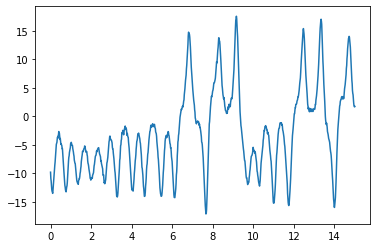

In [47]:
tpts, sol = Lorenz().make_trajectory(1000, noise=0.2, resample=True, return_times=True, pts_per_period=100)
plt.plot(tpts, sol[:, 0])

# tpts, sol = Lorenz().make_trajectory(100, noise=0.1, resample=True, return_times=True, pts_per_period=10)
# plt.plot(tpts, sol[:, 0], '.')

In [9]:
sol

array([[-1.76032441,  0.11421693,  0.28251434],
       [-1.74320248,  0.12254475,  0.9815227 ],
       [-1.7171558 ,  0.10169879,  0.98299165],
       ...,
       [        nan,         nan,  0.51832871],
       [        nan,         nan,  0.929088  ],
       [        nan,         nan,  0.99787527]])

In [ ]:
complete_flag = False
while not complete_flag:
    try:
        with timeout(seconds=3):
            tpts, sol = model.make_trajectory(num_periods[subset] * pts_per_period, pts_per_period=pts_per_period, 
                           resample=True, return_times=True)
            complete_flag = True
    except:
        np.random.random() # just to make sure seed iterates
        [new_ic] = sample_initial_conditions(model, 1)
        model.ic = new_ic
        print("Retrying...")

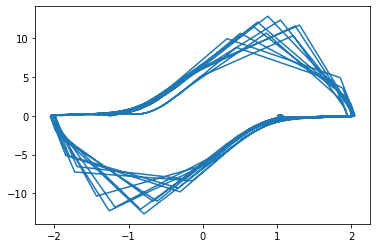

In [24]:
plt.plot(*np.array(values).T[:2], '-')

In [ ]:
(np.ptp(sol, axis=0)/np.ptp(xxxx, axis=0)) > 2.0

In [181]:
dir(getattr(dysts.flows, equation_name)())

['__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_data',
 '_postprocessing',
 '_rhs',
 'a',
 'bifurcation_parameter',
 'bound_trajectory',
 'citation',
 'correlation_dimension',
 'data_path',
 'delay',
 'description',
 'dt',
 'embedding_dimension',
 'get_param_names',
 'hamiltonian',
 'ic',
 'initial_conditions',
 'kaplan_yorke_dimension',
 'lyapunov_spectrum_estimated',
 'make_trajectory',
 'maximum_lyapunov_estimated',
 'mu',
 'multiscale_entropy',
 'name',
 'nonautonomous',
 'parameters',
 'params',
 'period',
 'pesin_entropy',
 'random_state',
 'rhs',
 'unbounded_indices',
 'w']

[2]

In [65]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])
    plt.title(equation_name + " " + str(getattr(dysts.flows, equation_name)().correlation_dimension))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 432x288 with 0 Axes>

KeyError: 'values'

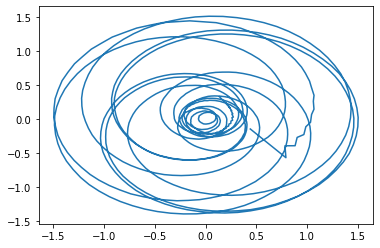

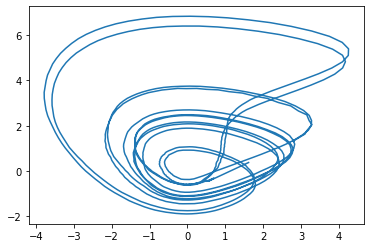

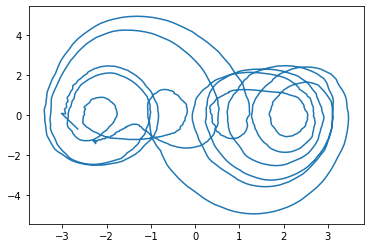

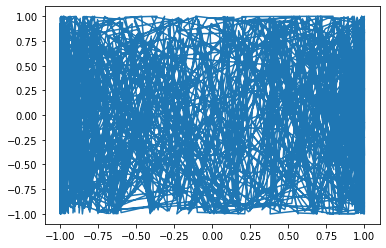

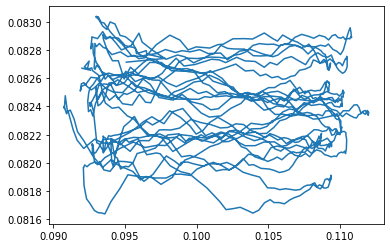

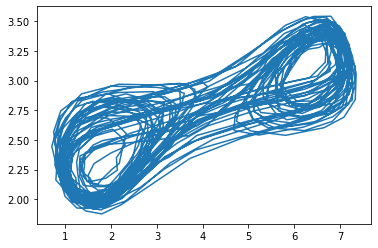

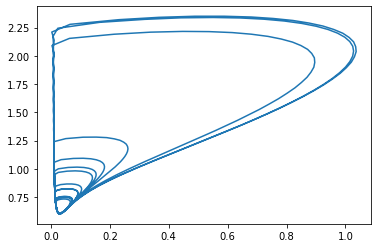

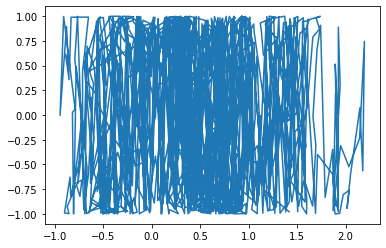

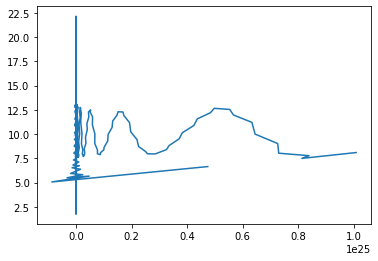

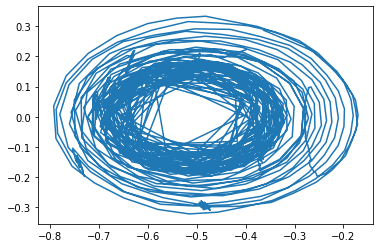

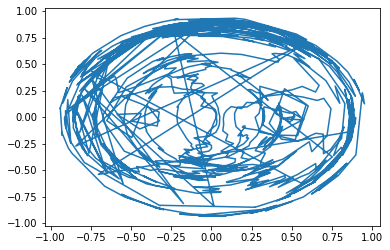

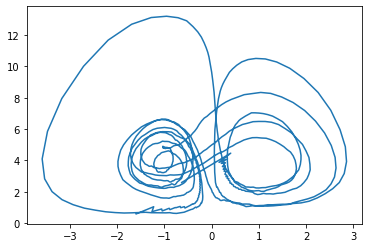

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
for equation_name in list(dataset.keys())[:19]:
    plt.figure()
    #plt.plot(np.array(dataset[equation_name]["values"]))
    plt.plot(np.array(dataset[equation_name]["values"])[:, 0],np.array(dataset[equation_name]["values"])[:, 1])

In [22]:
%matplotlib inline

plt.plot(np.array(dataset['SprottR']["values"])[:, 0],np.array(dataset['SprottR']["values"])[:, 1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed